# DOGS V CATS DATASET

- Web services are often protected with a challenge that's supposed to be easy for people to solve, but difficult for computers. Such a challenge is often called a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) or HIP (Human Interactive Proof). HIPs are used for many purposes, such as to reduce email and blog spam and prevent brute-force attacks on web site passwords.

- Asirra (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately. Many even think it's fun! Here is an example of the Asirra interface:

- Asirra is unique because of its partnership with Petfinder.com, the world's largest site devoted to finding homes for homeless pets. They've provided Microsoft Research with over three million images of cats and dogs, manually classified by people at thousands of animal shelters across the United States. Kaggle is fortunate to offer a subset of this data for fun and research. 

In [12]:
# IMPORTS
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf

%matplotlib inline

### DATA PREPROCESSING

In [2]:
TRAIN_DIR='D:/Courses/ADS/Python Files/train'
TEST_DIR='D:/Courses/ADS/Python Files/test1'
IMG_SIZE=50 #50x50
LR=1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR,'2conv-basic-video')

In [3]:
def label_img(img):
    #dog.93.png
    word_label=img.split('.')[-3]
    if word_label == 'cat': return[1,0]
    elif word_label== 'dog': return[0,1]

In [4]:
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label=label_img(img)
        path=os.path.join(TRAIN_DIR,img)
        img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data

In [5]:
def process_test_data():
    testing_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path=os.path.join(TEST_DIR,img)
        img_num=img.split('.')[0]
        img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),np.array(img_num)])
    np.save('test_data.npy',testing_data)
    return testing_data

In [6]:
#train_data= create_train_data()
#if Already have a train data
train_data=np.load('train_data.npy')

In [7]:
#If you dont have the file yet
#test_data=process_test_data()
#if you have it
test_data=np.load('test_data.npy')

In [20]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet,tensorboard_dir='log')

In [16]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('Model Loaded!')

In [17]:
train=train_data[:-500]
test=train_data[-500:]

In [18]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y= [i[1] for i in test]

In [11]:
sess=tf.Session()

In [21]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 11.04450 | time: 103.083s
| Adam | epoch: 003 | loss: 11.04450 - acc: 0.5203 -- iter: 24448/24500
Training Step: 1149  | total loss: 10.94743 | time: 104.351s
| Adam | epoch: 003 | loss: 10.94743 - acc: 0.5246 | val_loss: 11.78924 - val_acc: 0.4880 -- iter: 24500/24500
--


In [35]:
#tensorboard --logdir=fooD:\Courses\ADS\Python Files\log

writer = tf.summary.FileWriter(graph, sess.graph)
writer.close()
sess.close()

In [36]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\kaush\Python Files\dogsvscats-0.001-6conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


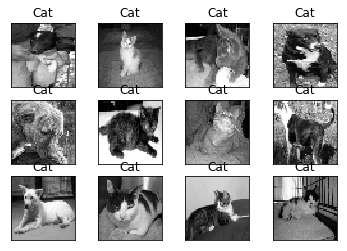

In [23]:
fig=plt.figure()
for num,data in enumerate(test_data[:12]):
    #cat:[1:0]
    #dog:[0:1]
    
    img_num=data[1]
    img_data=data[0]
    
    y= fig.add_subplot(3,4,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out=model.predict([data])[0]
    
    if np.argmax(model_out)==1: str_label='Dog'
    else: str_label='Cat'
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()


### Changing Network Architecture

Previous Model had given us the loss of 10 while the accuracy was 0.5. Now, lets see if we can improve the accuracy by increasing the the number of layers.

In [24]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet,tensorboard_dir='log')

In [25]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.59685 | time: 63.175s
| Adam | epoch: 003 | loss: 0.59685 - acc: 0.6753 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.59481 | time: 64.359s
| Adam | epoch: 003 | loss: 0.59481 - acc: 0.6828 | val_loss: 0.62092 - val_acc: 0.6440 -- iter: 24500/24500
--


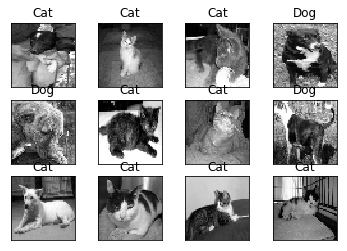

In [26]:
fig=plt.figure()
for num,data in enumerate(test_data[:12]):
    #cat:[1:0]
    #dog:[0:1]
    
    img_num=data[1]
    img_data=data[0]
    
    y= fig.add_subplot(3,4,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out=model.predict([data])[0]
    
    if np.argmax(model_out)==1: str_label='Dog'
    else: str_label='Cat'
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()


From the graph plotted above we can infer that the accuracy has increased and we can see a considerable improvement in the loss without changing the cost function. Thus, we can infer that changing the network architecture results into better accuracy and decrease in value of loss by a greater margin.

### Changing Activation Function and Epochs

Previously, We saw that changing the netork achitecture resulted improved the accuracy of the model and reduced the loss. Now lets try changing the Activation Function and Number of Epochs and check whether the accuracy increase or not.

In [49]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='TanH')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet,tensorboard_dir='log')

In [50]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.49594 | time: 69.333s
| Adam | epoch: 003 | loss: 0.49594 - acc: 0.7649 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.48346 | time: 70.526s
| Adam | epoch: 003 | loss: 0.48346 - acc: 0.7712 | val_loss: 0.49459 - val_acc: 0.7540 -- iter: 24500/24500
--


In [51]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3063  | total loss: 0.35336 | time: 67.821s
| Adam | epoch: 008 | loss: 0.35336 - acc: 0.8487 -- iter: 24448/24500
Training Step: 3064  | total loss: 0.35026 | time: 68.989s
| Adam | epoch: 008 | loss: 0.35026 - acc: 0.8513 | val_loss: 0.51066 - val_acc: 0.7780 -- iter: 24500/24500
--


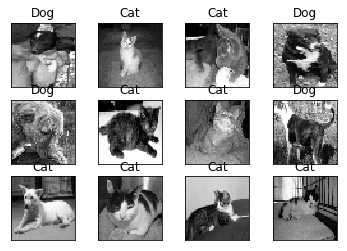

In [52]:
fig=plt.figure()
for num,data in enumerate(test_data[:12]):
    #cat:[1:0]
    #dog:[0:1]
    
    img_num=data[1]
    img_data=data[0]
    
    y= fig.add_subplot(3,4,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out=model.predict([data])[0]
    
    if np.argmax(model_out)==1: str_label='Dog'
    else: str_label='Cat'
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

We can see that the Model provides better accuracy and improves the loss when we change the activation function and number of epochs. Since we have got a good accuracy from the changes we made in our model, we will try to improve the model by changing the Cost Function.

### Changing Cost Function

In [53]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='TanH')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='mean_square', name='targets')

model = tflearn.DNN(convnet,tensorboard_dir='log')

In [54]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1914  | total loss: 0.14947 | time: 68.067s
| Adam | epoch: 005 | loss: 0.14947 - acc: 0.7949 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.14466 | time: 69.231s
| Adam | epoch: 005 | loss: 0.14466 - acc: 0.8013 | val_loss: 0.16012 - val_acc: 0.7680 -- iter: 24500/24500
--


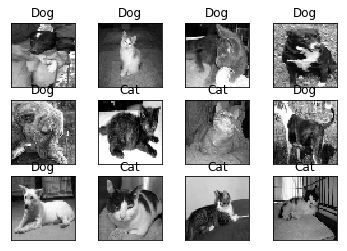

In [55]:
fig=plt.figure()
for num,data in enumerate(test_data[:12]):
    #cat:[1:0]
    #dog:[0:1]
    
    img_num=data[1]
    img_data=data[0]
    
    y= fig.add_subplot(3,4,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out=model.predict([data])[0]
    
    if np.argmax(model_out)==1: str_label='Dog'
    else: str_label='Cat'
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

By changing the Cost Function we can infer that the loss hass improved considerably and the value has come closer to zero whereas the accuracy hasn't affected that much. Owing to changes made in the model, lets try to change the Gradient Estimation and check wheater the model gives better results than before. 

### Changing Gradient Estimation

In [23]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='TanH')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='sgd', learning_rate=LR, loss='mean_square', name='targets')

model = tflearn.DNN(convnet,tensorboard_dir='log')

In [57]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1914  | total loss: 0.24996 | time: 79.161s
| SGD | epoch: 005 | loss: 0.24996 - acc: 0.4938 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.24995 | time: 80.394s
| SGD | epoch: 005 | loss: 0.24995 - acc: 0.5022 | val_loss: 0.25002 - val_acc: 0.5080 -- iter: 24500/24500
--


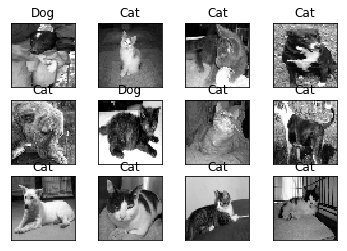

In [58]:
fig=plt.figure()
for num,data in enumerate(test_data[:12]):
    #cat:[1:0]
    #dog:[0:1]
    
    img_num=data[1]
    img_data=data[0]
    
    y= fig.add_subplot(3,4,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out=model.predict([data])[0]
    
    if np.argmax(model_out)==1: str_label='Dog'
    else: str_label='Cat'
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

By Changing the Gradient Descent Estimator, we can clearly see the change in the accuracy and loss. This change has reduced the accuracy while increasing the loss, Hence we can say that its better to use ADAM as optimizer than useing Schochastic Gradient Descent atleast for this model. Now keeping the old model into account since I gave a better result, Lets try to change the weights_initialization from uniform_scaling to variance_scaling and see the results. 

#### Changing Network Initialization

In [24]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='TanH',weights_init='variance_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH',weights_init='variance_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='TanH',weights_init='variance_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH',weights_init='variance_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='TanH',weights_init='variance_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH',weights_init='variance_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='TanH',weights_init='variance_scaling')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax',weights_init='variance_scaling')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='mean_square', name='targets')

model = tflearn.DNN(convnet,tensorboard_dir='log')

In [25]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1914  | total loss: 0.18067 | time: 71.442s
| Adam | epoch: 005 | loss: 0.18067 - acc: 0.7358 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.17621 | time: 72.617s
| Adam | epoch: 005 | loss: 0.17621 - acc: 0.7435 | val_loss: 0.18191 - val_acc: 0.7360 -- iter: 24500/24500
--


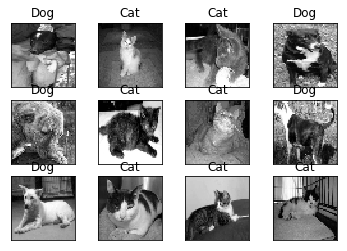

In [61]:
fig=plt.figure()
for num,data in enumerate(test_data[:12]):
    #cat:[1:0]
    #dog:[0:1]
    
    img_num=data[1]
    img_data=data[0]
    
    y= fig.add_subplot(3,4,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out=model.predict([data])[0]
    
    if np.argmax(model_out)==1: str_label='Dog'
    else: str_label='Cat'
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

In [26]:
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR,'8conv-basic-video')

In [28]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='TanH',weights_init='uniform_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH',weights_init='uniform_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='TanH',weights_init='uniform_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH',weights_init='uniform_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='TanH',weights_init='uniform_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH',weights_init='uniform_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='TanH',weights_init='uniform_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='TanH',weights_init='uniform_scaling')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='TanH',weights_init='uniform_scaling')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax',weights_init='uniform_scaling')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='mean_square', name='targets')

model = tflearn.DNN(convnet,tensorboard_dir='log')

In [29]:
model.fit({'input': X}, {'targets': Y}, n_epoch=8, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3063  | total loss: 0.11718 | time: 75.715s
| Adam | epoch: 008 | loss: 0.11718 - acc: 0.8456 -- iter: 24448/24500
Training Step: 3064  | total loss: 0.12151 | time: 76.904s
| Adam | epoch: 008 | loss: 0.12151 - acc: 0.8376 | val_loss: 0.17979 - val_acc: 0.7480 -- iter: 24500/24500
--


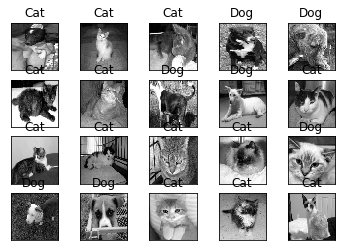

In [32]:
fig=plt.figure()
for num,data in enumerate(test_data[:20]):
    #cat:[1:0]
    #dog:[0:1]
    
    img_num=data[1]
    img_data=data[0]
    
    y= fig.add_subplot(4,5,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out=model.predict([data])[0]
    
    if np.argmax(model_out)==1: str_label='Dog'
    else: str_label='Cat'
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

In [31]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\kaush\Python Files\dogsvscats-0.001-8conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


Previous Model provided the best val_accuracy untill now and also got the lowest val_loss hence we can infer that, by selecting the appropriate Activation Function, Cost Function, Gradient estimation , Number of Rpochs, Network Architecture and Network Initialization from various options in each field, we can develop a model that can provide us the best result and each factor plays an important role in a specific field to improve the accuracy and gives the minimun loss. 


**For our Model approprate features are as follows: **
- Activation function:Initially I used ReLU as an activation function from which I got accuracy of 60% but when I changed it to TanH the accuracy increased to 80%
- Cost function: Changing the Cost Function from categorical_crossentropy to mean_squarred resulted in reducing the loss considerably and increaing the accuracy.
- Epochs: More the number of epochs, better will be the result
- Gradient estimation: ADAM and Schotastic Gradient Descent
- Network Architecture: Altering Number of Layers Provided better result
- Network initialization: Changing the weights_initialization from uniform_scaling to variance_scaling resulted into reducing the accuracy considerably and increasing the val_loss by a short margin. 
